In [1]:
# importing packages
import numpy as np
import pandas as pd
import sqlite3
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

In [142]:
budgets

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,2009-12-18,Avatar,425000000,760507625,2776345279
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875
2,3,2019-06-07,Dark Phoenix,350000000,42762350,149762350
3,4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747
...,...,...,...,...,...,...
5777,78,2018-12-31,Red 11,7000,0,0
5778,79,1999-04-02,Following,6000,48482,240495
5779,80,2005-07-13,Return to the Land of Wonders,5000,1338,1338
5780,81,2015-09-29,A Plague So Pleasant,1400,0,0


# Actors

In this section, we work on finding the best choices of popular actors/actresses to suggest as part of the main cast 
First of all, We will find the optimal number of main characters for the new production.
Then, we will determine which actors are public favorites.


In [127]:
cast_counts_n_ratings = pd.read_sql(""" 
    SELECT 
        a.movie_id,
        cast_count,
        averagerating
    FROM
    (
        SELECT 
            movie_id 
            ,count(distinct person_id) cast_count
        FROM principals
        WHERE category IN ('actor','actress')
            and movie_id IN (SELECT movie_id FROM movie_basics WHERE start_year >= 2015)
        GROUP BY movie_id
    ) as a
    INNER JOIN 
        movie_ratings as mr
    on a.movie_id = mr.movie_id
""",conn)

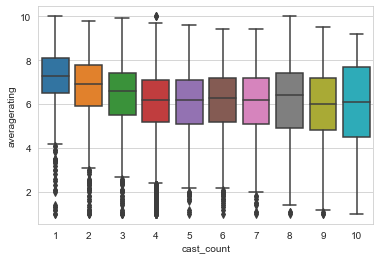

In [133]:
sns.boxplot(x ="cast_count", y ="averagerating",
            data = cast_counts_n_ratings);

If we calculate the pearson coefficient of **cast_count** vs **averagerating** we get the following

In [199]:
corr, _ = stats.pearsonr(list(cast_counts_n_ratings['cast_count']),list(cast_counts_n_ratings['averagerating']))
print('pearson :',round(corr,3))

pearson : -0.096


Therefore, there is no relation between the number of main characters (principal actors/actresses) and the average rating of the movies. 
Then we can stick to choose as many as the average number of actors 

Then, we will be sugesting to have as many as overall mean number of actors/actresses in the movie

Mean:  4.17
Standard dev:  1.33


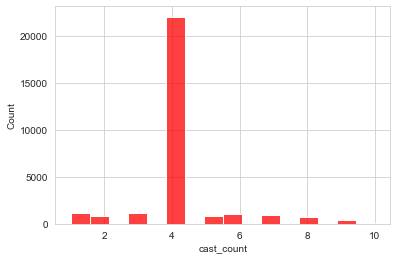

In [218]:
#cast_counts_n_ratings.set_index('movie_id',inplace = True)
sns.set_style('whitegrid')
sns.histplot(cast_counts_n_ratings['cast_count'], kde = False, color ='red', bins = 'auto')
print('Mean: ',round(cast_counts_n_ratings['cast_count'].mean(),2));
#print('Mode: ',cast_counts_n_ratings['cast_count'].mode(),2);
print('Standard dev: ',round(cast_counts_n_ratings['cast_count'].std(),2));

Based on the popularity (the total number of reviews an actor has), and sorting by average rating of the movies they have been on in the latest years (> 2015) we can sugest a list of the best actors/actresses to choose form.

In [164]:
conn = sqlite3.connect('Data/im.db')

act_base = pd.read_sql("""
    SELECT 
        ps.person_id
        ,ps.primary_name
        ,category
        ,avg(mr.averagerating)/10 as avg_rating
        ,sum(mr.numvotes) as total_ratings
    FROM principals as pr
    INNER JOIN
        persons as ps
        on ps.person_id = pr.person_id
    INNER JOIN 
        movie_ratings as mr
        on mr.movie_id = pr.movie_id
    WHERE pr.category IN ('actor','actress')
            and death_year is NUll
            and mr.movie_id IN (SELECT movie_id FROM movie_basics WHERE start_year >= 2015)
    GROUP BY 
        ps.person_id
        ,ps.primary_name
    HAVING sum(mr.numvotes)>20
    ORDER BY
        total_ratings DESC
        ,avg_rating DESC
""",conn)

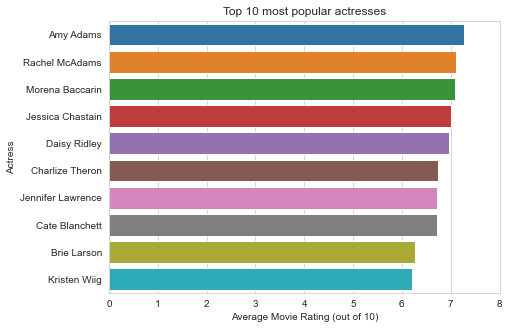

In [230]:
dt = act_base[act_base['category']=='actress'].iloc[:10].sort_values(by=['avg_rating'], ascending = False);
plt.figure(figsize=(7,5));
sns.barplot(x='avg_rating', y='primary_name', data = dt );
plt.xlabel('Average Movie Rating (out of 10)');
plt.xticks([a/10 for a in list(range(9))], list(range(9))) ;
plt.ylabel('Actress');
plt.title('Top 10 most popular actresses');
plt.savefig('top10actresses.png')

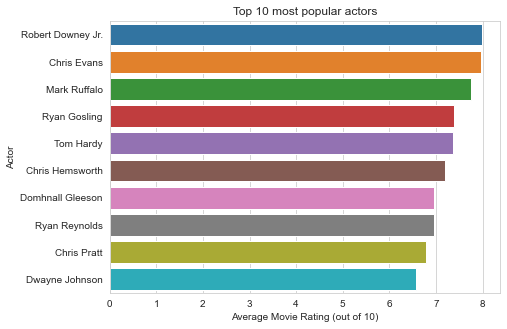

In [231]:
dt = act_base[act_base['category']=='actor'].iloc[:10].sort_values(by=['avg_rating'], ascending = False)
plt.figure(figsize=(7,5));
sns.barplot(x='avg_rating', y='primary_name', data = dt );
plt.xlabel('Average Movie Rating (out of 10)');
plt.xticks([a/10 for a in list(range(9))], list(range(9))) ;
plt.ylabel('Actor');
plt.title('Top 10 most popular actors');
plt.savefig('top10actors.png')

We suggest to select a total of 4 people to form the principal cast.
The above barplots show the most popular actors and acresses ordered by the average rating of the movies they participated in 

Now we will findout which of them have worked together before 

In [255]:
recomendations = pd.read_sql("""
    WITH act_base as (
    SELECT 
        ps.person_id
        ,ps.primary_name
        ,category
        ,avg(mr.averagerating)/10 as avg_rating
        ,sum(mr.numvotes) as total_ratings
    FROM principals as pr
    INNER JOIN
        persons as ps
        on ps.person_id = pr.person_id
    INNER JOIN 
        movie_ratings as mr
        on mr.movie_id = pr.movie_id
    WHERE pr.category IN ('actor','actress')
            and death_year is NUll
            and mr.movie_id IN (SELECT movie_id FROM movie_basics WHERE start_year >= 2015)
    GROUP BY 
        ps.person_id
        ,ps.primary_name
    HAVING sum(mr.numvotes)>20
    ORDER BY
        total_ratings DESC
        ,avg_rating DESC
    )
    SELECT 
        principals.person_id
        ,primary_name
        ,movie_id
    FROM 
        principals
    INNER JOIN 
        persons
        on principals.person_id = persons.person_id
    WHERE 
        principals.person_id IN (SELECT person_id 
                                  FROM act_base 
                                  WHERE category = 'actor' 
                                  ORDER BY total_ratings DESC 
                                  LIMIT 10)
        OR principals.person_id IN (SELECT person_id 
                                     FROM act_base 
                                     WHERE category = 'actress' 
                                     ORDER BY total_ratings DESC 
                                     LIMIT 10)
    
""",conn)

The **recomendations** dataframe contains the list of actors and actresses we recomended and their respective movie participations

In [257]:
recomendations

,person_id,primary_name,movie_id
0,nm0010736,Amy Adams,tt1216492
1,nm1325419,Kristen Wiig,tt1478338
2,nm1046097,Rachel McAdams,tt1605783
3,nm0262635,Chris Evans,tt1706620
4,nm5397459,Daisy Ridley,tt2076822
...,...,...,...
354,nm1165110,Chris Hemsworth,tt8698020
355,nm0749263,Mark Ruffalo,tt7874330
356,nm1727304,Domhnall Gleeson,tt8376234
357,nm0010736,Amy Adams,tt6266538


The next chunk of code builds a matrix of actor/actress vs actor/actress that asigns the value of **1** if two actors/actresses have participated in the same movie before (since 2015), and 0 if not. 

In [258]:
#
act_dict = {'name':list(recomendations.primary_name.unique())}    
for act in act_dict['name']:
    act_dict[act] = []
    person_column_movies = list(recomendations[recomendations.primary_name == act].movie_id.unique())
    for act_match in list(recomendations.primary_name.unique()):
        movies_match_cnt = 0
        for movie in list(recomendations[recomendations.primary_name == act_match].movie_id.unique()):
            if movie in person_column_movies:
                movies_match_cnt += 1
            
        if movies_match_cnt > 0:
            act_dict[act].append(1)
        else :
            act_dict[act].append(0)    

In [259]:
pd.DataFrame.from_dict(act_dict)

,name,Amy Adams,Kristen Wiig,Rachel McAdams,Chris Evans,Daisy Ridley,Robert Downey Jr.,Dwayne Johnson,Chris Pratt,Jessica Chastain,...,Mark Ruffalo,Ryan Gosling,Domhnall Gleeson,Chris Hemsworth,Jennifer Lawrence,Cate Blanchett,Charlize Theron,Tom Hardy,Morena Baccarin,Brie Larson
0,Amy Adams,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
1,Kristen Wiig,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,Rachel McAdams,0,0,1,0,0,1,0,0,0,...,1,0,1,0,0,0,0,0,0,0
3,Chris Evans,0,0,0,1,0,1,0,0,0,...,1,0,0,1,0,0,0,0,0,0
4,Daisy Ridley,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
5,Robert Downey Jr.,0,0,1,1,0,1,0,0,0,...,1,0,0,1,0,0,0,0,0,0
6,Dwayne Johnson,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Chris Pratt,0,0,0,0,0,0,0,1,1,...,0,0,0,0,1,0,0,0,0,0
8,Jessica Chastain,0,1,0,0,0,0,0,1,1,...,0,0,0,1,0,0,1,0,0,0
9,Ryan Reynolds,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
